# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles for 100 robot steps then it is moved into another random location.
- The data is not normalized in this experiment.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

        - (0, 0, 0.05)
        - (10, 10, 0.05)
        
- The simulator runs during 10 hours of simulation (~10 minutes in fast mode).

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

Using TensorFlow backend.


# First Experiment

In [12]:
csv_file = 'robot_info_dataset.csv'
df = pd.read_csv(csv_file)
df[['x', 'y', 'theta', 'sensor_1', 'sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7', 'sensor_8']].head()

,x,y,theta,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8
0,1.050733,1.094226,308.240738,1.061660,1.289745,0.990510,0.577111,0.232157,0.279216,1.000384,1.083896
1,1.052836,1.093243,311.136141,1.129972,1.214009,1.135844,0.905048,0.365532,0.420028,0.993033,1.009313
2,1.054507,1.091473,315.074322,1.185616,1.131318,1.019394,1.015204,0.395438,0.405837,0.956272,0.944564
3,1.056316,1.089796,319.070072,1.098113,1.103999,1.094631,1.069772,0.391122,0.360150,0.881076,1.000029
4,1.058129,1.088026,323.456321,1.327904,1.104746,1.123384,1.032261,0.425896,0.358535,0.842176,0.892464


## Data pre-processing

The data collected 1384848 samples.

In [3]:
df.shape

(1125965, 23)

The data set contains some null values so they should be deleted from the samples.

In [4]:
df = df.dropna()

## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [5]:

# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
sampled_df = df.sample(frac=1)

# separate inputs from outputs
inputs = sampled_df[['x', 'y', 'theta']]
targets = sampled_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:]
test_targets = targets[train_size:]

inputs.head()

,x,y,theta
146915,0.611884,0.545137,116.209126
395607,0.657494,0.940486,91.794910
523395,1.188947,0.176346,9.464511
660813,1.436274,1.295263,25.279415
928856,1.719404,1.262293,81.929609


## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. One model per sensor will be created.

In [6]:

def get_model():
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(3,)))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [7]:
train_targets[['sensor_1']['sensor_1']][0:10]

,sensor_1
146915,0.863916
395607,0.582586
523395,0.718990
660813,0.513210
928856,0.242353
1004575,1.139518
534714,0.682843
708673,0.588983
296008,0.163155
911244,1.293282


In [8]:
def k_fold(sensor_number, num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[[sensor_number]][i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[[sensor_number]][:i * num_val_samples],
             train_targets[[sensor_number]][(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=64, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse


In [10]:
histories, nmse = k_fold('sensor_3', 50, 3)

processing fold # 0
Train on 600514 samples, validate on 300257 samples
Epoch 1/50
600514/600514 [==============================] - 29s 49us/step - loss: 0.2550 - mae: 0.3006 - val_loss: 0.2141 - val_mae: 0.3103
Epoch 2/50
600514/600514 [==============================] - 26s 43us/step - loss: 0.0365 - mae: 0.1363 - val_loss: 0.1581 - val_mae: 0.2660
Epoch 3/50
600514/600514 [==============================] - 26s 43us/step - loss: 0.0229 - mae: 0.1068 - val_loss: 0.1301 - val_mae: 0.2627
Epoch 4/50
600514/600514 [==============================] - 27s 45us/step - loss: 0.0172 - mae: 0.0920 - val_loss: 0.0101 - val_mae: 0.0734
Epoch 5/50
600514/600514 [==============================] - 29s 49us/step - loss: 0.0141 - mae: 0.0828 - val_loss: 0.0382 - val_mae: 0.1248
Epoch 6/50
600514/600514 [==============================] - 27s 45us/step - loss: 0.0120 - mae: 0.0764 - val_loss: 0.0154 - val_mae: 0.0911
Epoch 7/50
600514/600514 [==============================] - 28s 47us/step - loss: 0.0105

Epoch 16/50
600514/600514 [==============================] - 25s 41us/step - loss: 0.0067 - mae: 0.0562 - val_loss: 0.0053 - val_mae: 0.0500
Epoch 17/50
600514/600514 [==============================] - 24s 40us/step - loss: 0.0066 - mae: 0.0558 - val_loss: 0.0051 - val_mae: 0.0515
Epoch 18/50
600514/600514 [==============================] - 25s 41us/step - loss: 0.0065 - mae: 0.0554 - val_loss: 0.0089 - val_mae: 0.0698
Epoch 19/50
600514/600514 [==============================] - 24s 40us/step - loss: 0.0064 - mae: 0.0549 - val_loss: 0.0061 - val_mae: 0.0520
Epoch 20/50
600514/600514 [==============================] - 24s 40us/step - loss: 0.0062 - mae: 0.0544 - val_loss: 0.0072 - val_mae: 0.0640
Epoch 21/50
600514/600514 [==============================] - 23s 39us/step - loss: 0.0061 - mae: 0.0540 - val_loss: 0.0067 - val_mae: 0.0578
Epoch 22/50
600514/600514 [==============================] - 24s 41us/step - loss: 0.0061 - mae: 0.0537 - val_loss: 0.0070 - val_mae: 0.0653
Epoch 23/50
6

NMSE: 
0.023243289122821854


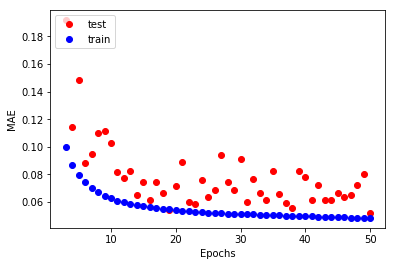

In [12]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 50
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


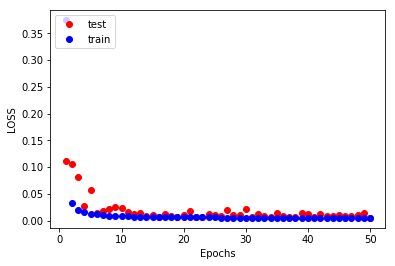

In [14]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [15]:
model = get_model()

history = model.fit(inputs, targets[['sensor_5']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_5.h5")

Epoch 1/50
1125964/1125964 [==============================] - 51s 45us/step - loss: 0.1089 - mae: 0.2125
Epoch 2/50
1125964/1125964 [==============================] - 48s 42us/step - loss: 0.0210 - mae: 0.1036
Epoch 3/50
1125964/1125964 [==============================] - 48s 43us/step - loss: 0.0143 - mae: 0.0845
Epoch 4/50
1125964/1125964 [==============================] - 48s 43us/step - loss: 0.0112 - mae: 0.0741 1s - loss: 0.0113 - mae: 0 - ETA: 1s - loss:
Epoch 5/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.0093 - mae: 0.0668
Epoch 6/50
1125964/1125964 [==============================] - 45s 40us/step - loss: 0.0082 - mae: 0.0622
Epoch 7/50
1125964/1125964 [==============================] - 45s 40us/step - loss: 0.0075 - mae: 0.0592
Epoch 8/50
1125964/1125964 [==============================] - 45s 40us/step - loss: 0.0072 - mae: 0.0575 1s - loss:
Epoch 9/50
1125964/1125964 [==============================] - 45s 40us/step - loss: 0.0069 - mae: 0.0563

In [16]:
model = get_model()

history = model.fit(inputs, targets[['sensor_6']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_6.h5")

Epoch 1/50
1125964/1125964 [==============================] - 47s 41us/step - loss: 0.1614 - mae: 0.2311
Epoch 2/50
1125964/1125964 [==============================] - 46s 41us/step - loss: 0.0211 - mae: 0.1028
Epoch 3/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.0140 - mae: 0.0835
Epoch 4/50
1125964/1125964 [==============================] - 46s 41us/step - loss: 0.0111 - mae: 0.0741 1s - loss: 0.011 - ETA: 0s - loss: 0.0111 - mae:
Epoch 5/50
1125964/1125964 [==============================] - 46s 41us/step - loss: 0.0093 - mae: 0.0680
Epoch 6/50
1125964/1125964 [==============================] - 47s 41us/step - loss: 0.0081 - mae: 0.0638
Epoch 7/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.0074 - mae: 0.0609
Epoch 8/50
1125964/1125964 [==============================] - 46s 41us/step - loss: 0.0070 - mae: 0.0589
Epoch 9/50
1125964/1125964 [==============================] - 46s 41us/step - loss: 0.0065 - mae: 0.0571
Epoch 

In [17]:
model = get_model()

history = model.fit(inputs, targets[['sensor_7']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_7.h5")

Epoch 1/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.6980 - mae: 0.2798
Epoch 2/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.0324 - mae: 0.1053 0s - loss: 0.0325 - mae: 0. - ETA: 0s - loss: 0.0325 - mae: 
Epoch 3/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.0243 - mae: 0.0844
Epoch 4/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.0210 - mae: 0.0738
Epoch 5/50
1125964/1125964 [==============================] - 47s 41us/step - loss: 0.0191 - mae: 0.0676
Epoch 6/50
1125964/1125964 [==============================] - 48s 42us/step - loss: 0.0181 - mae: 0.0640
Epoch 7/50
1125964/1125964 [==============================] - 48s 42us/step - loss: 0.0175 - mae: 0.0615
Epoch 8/50
1125964/1125964 [==============================] - 46s 41us/step - loss: 0.0171 - mae: 0.0600
Epoch 9/50
1125964/1125964 [==============================] - 47s 41us/step - loss: 0.0168 - mae: 0

In [18]:
model = get_model()
history = model.fit(inputs, targets[['sensor_8']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_8.h5")

Epoch 1/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.1722 - mae: 0.2077
Epoch 2/50
1125964/1125964 [==============================] - 49s 44us/step - loss: 0.1027 - mae: 0.1132
Epoch 3/50
1125964/1125964 [==============================] - 49s 43us/step - loss: 0.0957 - mae: 0.0974
Epoch 4/50
1125964/1125964 [==============================] - 51s 45us/step - loss: 0.0935 - mae: 0.0913
Epoch 5/50
1125964/1125964 [==============================] - 48s 43us/step - loss: 0.0927 - mae: 0.0882
Epoch 6/50
1125964/1125964 [==============================] - 48s 43us/step - loss: 0.0923 - mae: 0.0874
Epoch 7/50
1125964/1125964 [==============================] - 47s 42us/step - loss: 0.0918 - mae: 0.0862
Epoch 8/50
1125964/1125964 [==============================] - 49s 43us/step - loss: 0.0918 - mae: 0.0857
Epoch 9/50
1125964/1125964 [==============================] - 48s 43us/step - loss: 0.0917 - mae: 0.0850
Epoch 10/50
1125964/1125964 [==========================

In [19]:
model = get_model()

history = model.fit(inputs, targets[['sensor_1']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_1.h5")

Epoch 1/50
1125964/1125964 [==============================] - 50s 44us/step - loss: 0.3959 - mae: 0.2283
Epoch 2/50
1125964/1125964 [==============================] - 51s 45us/step - loss: 0.1047 - mae: 0.1166
Epoch 3/50
1125964/1125964 [==============================] - 50s 44us/step - loss: 0.0963 - mae: 0.0972
Epoch 4/50
1125964/1125964 [==============================] - 50s 44us/step - loss: 0.0937 - mae: 0.0893
Epoch 5/50
1125964/1125964 [==============================] - 51s 45us/step - loss: 0.0926 - mae: 0.0864
Epoch 6/50
1125964/1125964 [==============================] - 50s 45us/step - loss: 0.0920 - mae: 0.0846
Epoch 7/50
1125964/1125964 [==============================] - 51s 45us/step - loss: 0.0913 - mae: 0.0829
Epoch 8/50
1125964/1125964 [==============================] - 50s 45us/step - loss: 0.0913 - mae: 0.0828
Epoch 9/50
1125964/1125964 [==============================] - 49s 43us/step - loss: 0.0911 - mae: 0.0826 0s - loss: 0.091
Epoch 10/50
1125964/1125964 [=========

In [20]:
model = get_model()

history = model.fit(inputs, targets[['sensor_2']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_2.h5")

Epoch 1/50
1125964/1125964 [==============================] - 52s 46us/step - loss: 0.1017 - mae: 0.1933
Epoch 2/50
1125964/1125964 [==============================] - 50s 44us/step - loss: 0.0259 - mae: 0.0911
Epoch 3/50
1125964/1125964 [==============================] - 50s 44us/step - loss: 0.0207 - mae: 0.0749
Epoch 4/50
1125964/1125964 [==============================] - 51s 45us/step - loss: 0.0185 - mae: 0.0669
Epoch 5/50
1125964/1125964 [==============================] - 52s 46us/step - loss: 0.0174 - mae: 0.0625
Epoch 6/50
1125964/1125964 [==============================] - 50s 44us/step - loss: 0.0169 - mae: 0.0602
Epoch 7/50
1125964/1125964 [==============================] - 51s 45us/step - loss: 0.0166 - mae: 0.0587
Epoch 8/50
1125964/1125964 [==============================] - 51s 46us/step - loss: 0.0163 - mae: 0.0576
Epoch 9/50
1125964/1125964 [==============================] - 52s 47us/step - loss: 0.0161 - mae: 0.0566
Epoch 10/50
1125964/1125964 [==========================

In [21]:
model = get_model()

history = model.fit(inputs, targets[['sensor_3']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_3.h5")

Epoch 1/50
1125964/1125964 [==============================] - 39s 34us/step - loss: 0.2304 - mae: 0.2158
Epoch 2/50
1125964/1125964 [==============================] - 41s 36us/step - loss: 0.0172 - mae: 0.0910
Epoch 3/50
1125964/1125964 [==============================] - 43s 38us/step - loss: 0.0118 - mae: 0.0756
Epoch 4/50
1125964/1125964 [==============================] - 40s 36us/step - loss: 0.0095 - mae: 0.0678
Epoch 5/50
1125964/1125964 [==============================] - 42s 37us/step - loss: 0.0083 - mae: 0.0633
Epoch 6/50
1125964/1125964 [==============================] - 41s 36us/step - loss: 0.0076 - mae: 0.0606
Epoch 7/50
1125964/1125964 [==============================] - 41s 37us/step - loss: 0.0071 - mae: 0.0584
Epoch 8/50
1125964/1125964 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0568- ETA: 0s - loss: 0.00 - 42s 37us/step - loss: 0.0067 - mae: 0.0568
Epoch 9/50
1125964/1125964 [==============================] - 40s 36us/step - loss: 0.0064 - mae: 0

In [22]:
model = get_model()

history = model.fit(inputs, targets[['sensor_4']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_4.h5")

Epoch 1/50
1125964/1125964 [==============================] - 41s 37us/step - loss: 0.0883 - mae: 0.1975 5s 
Epoch 2/50
1125964/1125964 [==============================] - 39s 35us/step - loss: 0.0178 - mae: 0.0939
Epoch 3/50
1125964/1125964 [==============================] - 42s 37us/step - loss: 0.0118 - mae: 0.0757
Epoch 4/50
1125964/1125964 [==============================] - 41s 37us/step - loss: 0.0098 - mae: 0.0688
Epoch 5/50
1125964/1125964 [==============================] - 42s 37us/step - loss: 0.0088 - mae: 0.0648
Epoch 6/50
1125964/1125964 [==============================] - 41s 37us/step - loss: 0.0082 - mae: 0.0620 1s - loss
Epoch 7/50
1125964/1125964 [==============================] - 42s 37us/step - loss: 0.0076 - mae: 0.0599 5s - loss
Epoch 8/50
1125964/1125964 [==============================] - 42s 37us/step - loss: 0.0072 - mae: 0.0581 3s - loss:  - ETA: 2s - loss: 0.0072 - mae
Epoch 9/50
1125964/1125964 [==============================] - 42s 37us/step - loss: 0.0069 - 